# 1. Install packages

In [1]:
!pip install tensorflow opencv-python matplotlib albumentations 


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# 2. Import our packages and build image loading function

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import json
import numpy as np

In [3]:
def load_image(image):
    img = tf.io.read_file(image)
    img = tf.io.decode_jpeg(img)
    img = tf.image.resize(img, [224, 224])
    return img

In [4]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg', shuffle=True).map(load_image)

## Plot some training samples

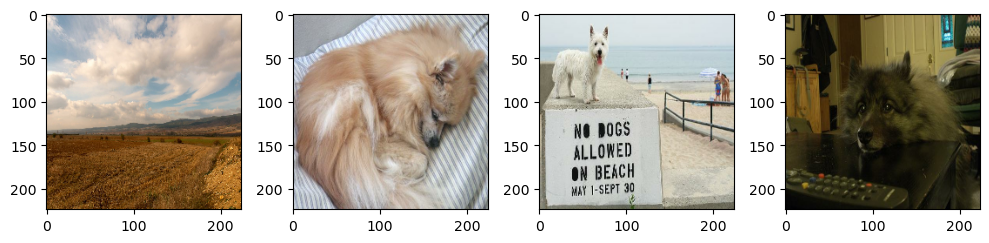

In [5]:
image_generator = images.batch(4).as_numpy_iterator()
plot_images = image_generator.next()
plot_images = plot_images / 255.0

fig, ax = plt.subplots(ncols=4, figsize=(10,10))
for id, img in enumerate(plot_images):
    ax[id].imshow(img)
fig.tight_layout()
plt.show()